In [1]:
# enter at past 10 candles 1h rsi 35 oversold, rsi_length 18, 15m cross k > d, 4h ema1 > ema3
# exit at 1h rsi 74 overbought
# stop loss 2 atr
# start time - 1609492611000, 1641028611000, 1672564611000 (2021, 2022, 2023)


In [2]:
# ! conda install -c conda-forge ta --yes

In [3]:
import requests
import pandas as pd
import pandas_ta as p_ta
import ta
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import time

In [4]:
def create_raw(symbol, interval_arr, start_time, end_time, step):
    
    url = "https://api.binance.com/api/v3/klines"
    
    for interval in interval_arr:

        raw_df = pd.DataFrame()
        
        for timestamp in range(start_time, end_time, step):
            params = {"symbol": symbol_C,
                      "interval": interval,
                      "startTime": timestamp,
                      "endTime": timestamp + step}
            response = requests.get(url, params=params).json()
            out = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                                   "Volume", "Close_Time", "Quote asset volume",
                                                   "Number of trades", "Taker buy base asset volume",
                                                   "Taker buy quote asset volume", "Ignore"])
            raw_df = pd.concat([raw_df, out], axis = 0)

        raw_df = raw_df[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]

        raw_df.to_hdf(f'klines_{symbol}_{interval}.h5', key='df', mode='w')
        print(f"Created {symbol}_{interval}")

In [5]:
interval_arr = ['15m', '1h', '4h', '1d']
start_time_arr = [1651366861000]
ema_arr = [8, 18, 38]

In [6]:
timezone = 8
symbol = 'ethusdt'
symbol_C = symbol.upper()
interval = '15m'

start_time = 1651366861000
end_time = round(time.time() * 1000)

# step between timestamps in milliseconds
step = 60000 * 3600

In [7]:
loop_start_time = time.time()
create_raw(symbol, interval_arr, min(start_time_arr), end_time, step)
loop_end_time = time.time()
print("Time taken to execute for loop:", loop_end_time - loop_start_time, "seconds")

Created ethusdt_15m
Created ethusdt_1h
Created ethusdt_4h
Created ethusdt_1d
Time taken to execute for loop: 45.437910079956055 seconds


In [8]:
h5 = pd.read_hdf(f'klines_{symbol}_{interval_arr[0]}.h5', key='df')
print(h5.tail(1))
print(len(h5))

        Close_Time           Open          Close           High  \
226  1681811999999  2107.41000000  2105.20000000  2109.69000000   

               Low         Volume  
226  2104.06000000  4409.52460000  
33822


In [9]:
klines_cache = {}

def get_klines(symbol, interval, start_time, end_time):
    if (symbol, interval) not in klines_cache:
        klines_cache[(symbol, interval)] = pd.read_hdf(f'klines_{symbol}_{interval}.h5', key='df')

    df = klines_cache[(symbol, interval)].query(f"Close_Time >= {start_time} and Close_Time <= {end_time}")

    df = df[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']].astype(float)
    df = df.set_index('Close_Time')
#     df = df.reset_index(drop=True)

    df.index = pd.to_datetime(df.index, unit='ms') + pd.Timedelta(hours=timezone)
    df = df[~df.index.duplicated(keep='first')]

    return df

In [10]:
def time_format(timezone):
#     df['Close_Time'] = pd.to_datetime(df['Close_Time'], unit='ms') + pd.Timedelta(hours=timezone)
#     df['Close_Time'] = df['Close_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    df.index = pd.to_datetime(df.index, unit='ms') + pd.Timedelta(hours=timezone)
    df.index = df.index.strftime('%Y-%m-%d %H:%M:%S')

In [11]:
bb_int = 30
bb_dev = 2
rsi_int = 18

In [12]:
df = get_klines(symbol, interval_arr[0], start_time, end_time).copy()
df = df.astype(float).round(2)

for interval in interval_arr:
    raw_df = get_klines(symbol, interval, start_time, end_time)
    
    # ema
    for ema in ema_arr:
        column_name = f'ema_{ema}_{interval}'
        df[column_name] = ta.trend.ema_indicator(raw_df.Close, window=ema)
    
    # bb
    bb = ta.volatility.BollingerBands(raw_df.Close, window=bb_int, window_dev=bb_dev)
    df[f'bb_u_{interval}'] = bb.bollinger_hband()
    df[f'bb_m_{interval}'] = bb.bollinger_mavg()
    df[f'bb_l_{interval}'] = bb.bollinger_lband()        

    # rsi
    rsi = ta.momentum.RSIIndicator(raw_df.Close, window = rsi_int)
    df[f'rsi_{interval}'] = rsi.rsi()
    
    # atr
    df['atr'] = ta.volatility.average_true_range(df.High, df.Low, df.Close)
    
# reset index and set current index as a column
df = df.reset_index()

# set new index with integers
df = df.set_index(pd.RangeIndex(len(df)))

# time_format(timezone)
df['Close_Time'] = df['Close_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')

print(df)
df.to_csv('df.csv')

                Close_Time     Open    Close     High      Low    Volume  \
0      2022-05-01 09:29:59  2738.40  2738.36  2742.95  2734.26   3623.65   
1      2022-05-01 09:44:59  2738.36  2768.97  2772.00  2725.40  11211.82   
2      2022-05-01 09:59:59  2768.97  2770.25  2777.36  2762.01   9232.89   
3      2022-05-01 10:14:59  2770.26  2773.27  2776.22  2765.86   4203.36   
4      2022-05-01 10:29:59  2773.27  2771.35  2780.62  2769.65   5154.44   
...                    ...      ...      ...      ...      ...       ...   
33816  2023-04-18 16:44:59  2097.90  2096.48  2099.18  2096.18   2364.59   
33817  2023-04-18 16:59:59  2096.48  2096.57  2098.01  2095.26   2787.38   
33818  2023-04-18 17:14:59  2096.57  2096.17  2097.03  2094.18   3393.74   
33819  2023-04-18 17:29:59  2096.17  2102.09  2102.36  2096.16   3375.82   
33820  2023-04-18 17:44:59  2102.09  2107.42  2109.97  2102.08   5718.51   

         ema_8_15m   ema_18_15m   ema_38_15m     bb_u_15m  ...  bb_m_4h  \
0           

In [13]:
# enter at past 10 candles 1h rsi 35 oversold, rsi_length 18, 15m cross k > d, 4h ema1 > ema3
# exit at 1h rsi 74 overbought
# stop loss 2 atr

In [14]:
rsi_up = 74
rsi_low = 35
kd_dir = 'Up'

In [15]:
def check_cross(df, kd_dir):
    up = df['slow_k'] > df['slow_d']
    down = df['slow_k'] < df['slow_d']
    if kd_dir == 'Up':
        return up.diff() & up
    if kd_dir == 'Any':
        return up.diff()
    if kd_dir == 'Down':
        return down.diff() & down


def indicators(df, kd_dir):

# # ema
#     for i in (8, 18, 38):
#         df['ema_'+str(i)] = ta.trend.ema_indicator(df.Close, window=i)

# # bband
#     bb_int = 30
#     bb_dev = 2
#     bb = ta.volatility.BollingerBands(df['Close'], window=bb_int, window_dev=bb_dev)
#     df['bb_u'] = bb.bollinger_hband()
#     df['bb_m'] = bb.bollinger_mavg()
#     df['bb_l'] = bb.bollinger_lband()        
        
# # atr
#     df['atr'] = ta.volatility.average_true_range(df.High, df.Low, df.Close)
    
# # rsi
#     rsi_int = 14
#     df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()

# kd
    kd_int = 14
    d_int = 3
   
    kd_df = pd.DataFrame()
    kd_df[str(kd_int) + '-Low'] = df['Low'].rolling(kd_int).min()
    kd_df[str(kd_int) + '-High'] = df['High'].rolling(kd_int).max()
    df['slow_k'] = (df['Close'] - kd_df[str(kd_int) + '-Low'])*100/(kd_df[str(kd_int) + '-High'] - kd_df[str(kd_int) + '-Low'])
    df['slow_d'] = df['slow_k'].rolling(d_int).mean()
    
# kd cross
    df['kd_cross'] = check_cross(df, kd_dir)

In [16]:
indicators(df, kd_dir)

In [17]:
df = df.replace('', np.nan)
df['ema_8_4h'] = df['ema_8_4h'].interpolate()
df['ema_38_4h'] = df['ema_38_4h'].interpolate()
df['rsi_1h'] = df['rsi_1h'].interpolate()

In [18]:
def conditions(df):
    # enter at past 10 candles 1h rsi 35 oversold, rsi_length 18, 15m cross k > d, 4h ema1 > ema3
    # exit at 1h rsi 74 overbought
    # stop loss 2 atr
    
    df['c1'] = False
    for i, row in df.iterrows():
        if i >= 10:
            if (df.loc[i-10:i-1, 'rsi_1h'] < rsi_low).any():
                df.loc[i, 'c1'] = True
                
        df['c2'] = df['kd_cross']
        
        df['c3'] = df[f'ema_{ema_arr[0]}_4h'] >= df[f'ema_{ema_arr[2]}_4h']



    # 條件達成
    df['signal'] = False
    df.loc[df.c1 & df.c2 & df.c3, 'signal'] = True

#     print(df)

    # 下一根進場
    df['openbuy'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'openbuy'] = True
    
    df.to_csv('df.csv')

    return df

In [19]:
conditions(df)

,Close_Time,Open,Close,High,Low,Volume,ema_8_15m,ema_18_15m,ema_38_15m,bb_u_15m,...,bb_l_1d,rsi_1d,slow_k,slow_d,kd_cross,c1,c2,c3,signal,openbuy
0,2022-05-01 09:29:59,2738.40,2738.36,2742.95,2734.26,3623.65,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False
1,2022-05-01 09:44:59,2738.36,2768.97,2772.00,2725.40,11211.82,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False
2,2022-05-01 09:59:59,2768.97,2770.25,2777.36,2762.01,9232.89,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False
3,2022-05-01 10:14:59,2770.26,2773.27,2776.22,2765.86,4203.36,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False
4,2022-05-01 10:29:59,2773.27,2771.35,2780.62,2769.65,5154.44,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33816,2023-04-18 16:44:59,2097.90,2096.48,2099.18,2096.18,2364.59,2098.534197,2094.714563,2088.862015,2109.190617,...,NaN,NaN,44.391972,55.053201,False,False,False,True,False,False
33817,2023-04-18 16:59:59,2096.48,2096.57,2098.01,2095.26,2787.38,2098.097709,2094.909873,2089.257296,2108.993456,...,NaN,NaN,42.670478,47.076873,False,False,False,True,False,False
33818,2023-04-18 17:14:59,2096.57,2096.17,2097.03,2094.18,3393.74,2097.669329,2095.042518,2089.611793,2109.129342,...,NaN,NaN,36.638877,41.233775,False,False,False,True,False,False
33819,2023-04-18 17:29:59,2096.17,2102.09,2102.36,2096.16,3375.82,2098.651700,2095.784358,2090.251701,2109.647458,...,NaN,NaN,60.755412,46.688256,True,False,True,True,False,False


In [20]:
sl_atr = 5

In [21]:
entry_df = conditions(df).copy()

in_position = False
stop_loss = np.nan
take_profit = np.nan
close_val = entry_df['Close']
atr_val = entry_df['atr']


for index, row in entry_df.iterrows():

    if index == 0:
        continue
    
    elif entry_df.at[index, 'openbuy'] == True:
   
        entry_df.at[index, 'entry_p'] = close_val.shift(1).at[index]
        entry_df.at[index, 'stop_loss'] = close_val.shift(1).at[index] - sl_atr * atr_val.shift(1).at[index]
#         entry_df.at[index, 'take_profit'] = close_val.shift(1).at[index] + tp_atr * atr_val.shift(1).at[index]
        entry_df.at[index, 'position'] = 'Buy'
        in_position = True
        stop_loss = entry_df.at[index, 'stop_loss']
#         take_profit = entry_df.at[index, 'take_profit']
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position == True and (entry_df.at[index, 'Close'] <= stop_loss):
        entry_df.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan
        take_profit = np.nan

    # set take profit
    elif in_position == True and (entry_df.at[index, 'rsi_1h'] >= rsi_up):
        entry_df.at[index, 'position'] = 'Sell'
        in_position = False
        stop_loss = np.nan
#         take_profit = np.nan
        entry_df.at[index, 'take_profit'] = close_val.at[index]
        
entry_df.to_csv('entry_df.csv')
        
raw_entry_df = entry_df.copy()

# 過濾有訊號或事件發生的Ｋ線
entry_df = entry_df[(entry_df['openbuy'] == True) |
              (entry_df['signal'] == True) | 
              (entry_df['position'] == 'Buy') |
              (entry_df['position'] == 'Sell') |
              (entry_df['position'] == 'Stop')]

print(entry_df)

                Close_Time     Open    Close     High      Low    Volume  \
3037   2022-06-02 00:44:59  1853.44  1861.18  1867.39  1852.30  27574.87   
3038   2022-06-02 00:59:59  1861.17  1857.27  1863.07  1854.39   8884.44   
3039   2022-06-02 01:14:59  1857.28  1847.02  1858.66  1836.42  22780.02   
3040   2022-06-02 01:29:59  1847.01  1838.77  1850.18  1827.46  17769.64   
3047   2022-06-02 03:14:59  1818.89  1820.76  1821.88  1807.83  23772.55   
...                    ...      ...      ...      ...      ...       ...   
33231  2023-04-12 14:29:59  1862.42  1864.28  1865.01  1860.99   4369.14   
33232  2023-04-12 14:44:59  1864.27  1867.74  1868.03  1864.26   2401.60   
33238  2023-04-12 16:14:59  1870.30  1871.64  1872.20  1869.59   3269.31   
33239  2023-04-12 16:29:59  1871.65  1869.16  1874.22  1869.04   2859.42   
33340  2023-04-13 17:44:59  1985.76  1980.00  1989.31  1977.71  14890.91   

         ema_8_15m   ema_18_15m   ema_38_15m     bb_u_15m  ...  kd_cross  \
3037   1881

In [22]:
# 部位回測

pos_df = entry_df.copy()
pos_df = pos_df.reset_index(drop = True)
pos_df = pos_df[(pos_df['position'] == 'Buy') |
              (pos_df['position'] == 'Sell') |
              (pos_df['position'] == 'Stop')]

# 一次進場多少單位
pos_size = 1

col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'atr', 'kd_cross', 'position','entry_p', 'stop_loss', 'take_profit']
pos = pos_df[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'size'] = pos_size
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：達成條件時收盤價
        if pos.at[index, 'position'] == 'Sell':
#             pos.at[index, 'exit_p'] = pos.at[index, 'Close']
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[index, 'take_profit']
                break

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            pos.at[index, 'exit_p'] = pos.at[index, 'Open']
#             for i in range(index -1, -1, -1):
#                 if pos.at[i, 'position'] == 'Buy':
#                     pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
#                 break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Buy':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)


# 若最後一筆為 Buy，移除該單，迭代驗證
for index, row in pos.iloc[::-1].iterrows():
    if row['position'] == 'Buy':
        pos = pos.drop(index)
    else:
        break


# 手續費、滑點、價差
fee = 0.05 / 100
amt_abs_sum = pos.amt.abs().sum()
ttl_fee = amt_abs_sum * fee


# 損益
leverage = 10
ttl_profit = -pos.amt.sum() - ttl_fee


# 計算獲利/虧損次數
agg_amts = []

for i in range(len(pos) - 1, -1, -1):

    if pos.loc[i, 'position'] in ['Stop', 'Sell']:
        
        # look out for the + sign
        total_amt = pos.loc[i, 'amt'] + np.absolute(pos.loc[i, 'amt']) * fee
        
        # iterate backwards from the current row until reaching another 'Stop' or 'Sell'
        # watch out for the + in total_amt += trading_fee
        j = i - 1
        while j >= 0 and pos.loc[j, 'position'] not in ['Stop', 'Sell']:
            total_amt += pos.loc[j, 'amt']
            trading_fee = np.absolute(pos.loc[j, 'amt']) * fee
            total_amt += trading_fee
            j -= 1
        
        # add the aggregated amount to the list
        agg_amts.append(total_amt)

agg_amts.reverse()


# 計算進場最大部位，最大損益
consec_entry = 0
position_amt_sum = 0
max_consec_entry = 0
max_position = 0
max_profit = 0
max_loss = 0

for index, row in pos.iterrows():
    
    if row['position'] == 'Buy':
        
        consec_entry += 1
        position_amt_sum += row['amt']
        
    elif row['position'] in ['Sell', 'Stop']:
        
        if consec_entry > max_consec_entry:
            max_consec_entry = consec_entry
            max_position = position_amt_sum
            
        position_amt_sum += row['amt']
        
        if -position_amt_sum > max_profit:
            max_profit = -position_amt_sum
            
        if -position_amt_sum < max_loss:
            max_loss = -position_amt_sum
            
        consec_entry = 0
        position_amt_sum = 0
    
    else:
        pass

# 最大部位
profit_per = "{:.2f}%".format(ttl_profit / (max_position/leverage) * 100)


# 勝率
wins = 0
loses = 0

for trade in agg_amts:
    if trade < 0:
        wins += 1
    elif trade > 0:
        loses += 1

win_rate = "{:.2f}%".format(wins / (wins + loses) * 100)


# 結果
result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Max_Profit': [round(max_profit, 2)],
          'Max_Loss': [round(max_loss, 2)],
          'Max_Entry': [max_consec_entry],
          'Max_Position': [round(max_position, 2)],
          'Profit_%': [profit_per],
          'Win_Rate': [win_rate]}


result_df = pd.DataFrame(result)

print(result_df)
print()
print(pos)

pos.to_csv('pos.csv')


    Profit    Fee  Max_Profit  Max_Loss  Max_Entry  Max_Position Profit_%  \
0  3872.33  209.2     1365.27   -555.05         12      14015.57  276.29%   

  Win_Rate  
0   42.31%  

              Close_Time     Open    Close     High      Low        atr  \
0    2022-06-02 00:59:59  1861.17  1857.27  1863.07  1854.39  15.733048   
1    2022-06-02 01:29:59  1847.01  1838.77  1850.18  1827.46  16.663699   
2    2022-06-02 03:29:59  1820.77  1815.14  1827.47  1814.11  16.115537   
3    2022-06-02 04:59:59  1778.80  1793.17  1798.31  1777.07  17.789974   
4    2022-06-06 17:44:59  1901.89  1905.19  1906.27  1901.81   8.697633   
..                   ...      ...      ...      ...      ...        ...   
157  2023-04-12 12:29:59  1865.44  1866.64  1866.79  1864.40   6.246121   
158  2023-04-12 13:14:59  1867.65  1867.44  1868.94  1866.78   5.592134   
159  2023-04-12 14:44:59  1864.27  1867.74  1868.03  1864.26   4.898725   
160  2023-04-12 16:29:59  1871.65  1869.16  1874.22  1869.04   4.405

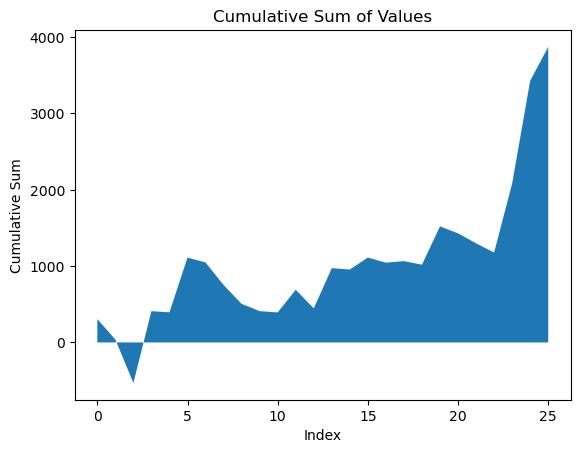

[305.53574, 38.21807000000035, -530.5699749999991, 409.634900000003, 394.2628650000034, 1111.6026150000023, 1048.221695000002, 752.2795050000021, 505.2999100000007, 409.87787500000087, 392.80445000000094, 689.593530000001, 446.1211550000005, 973.3139550000009, 955.3969750000011, 1111.9299850000014, 1045.1989750000007, 1065.2754599999996, 1018.7055749999994, 1520.8647349999999, 1429.193509999999, 1298.4909049999976, 1177.7412499999978, 2082.2132049999977, 3429.0321399999975, 3872.327634999998]


In [23]:
cumulative_values = []
cumulative_sum = 0
for value in agg_amts:
    cumulative_sum -= value
    cumulative_values.append(cumulative_sum)

plt.fill_between(range(len(cumulative_values)), cumulative_values, 0)

plt.xlabel('Index')
plt.ylabel('Cumulative Sum')
plt.title('Cumulative Sum of Values')

plt.show()

print(cumulative_values)

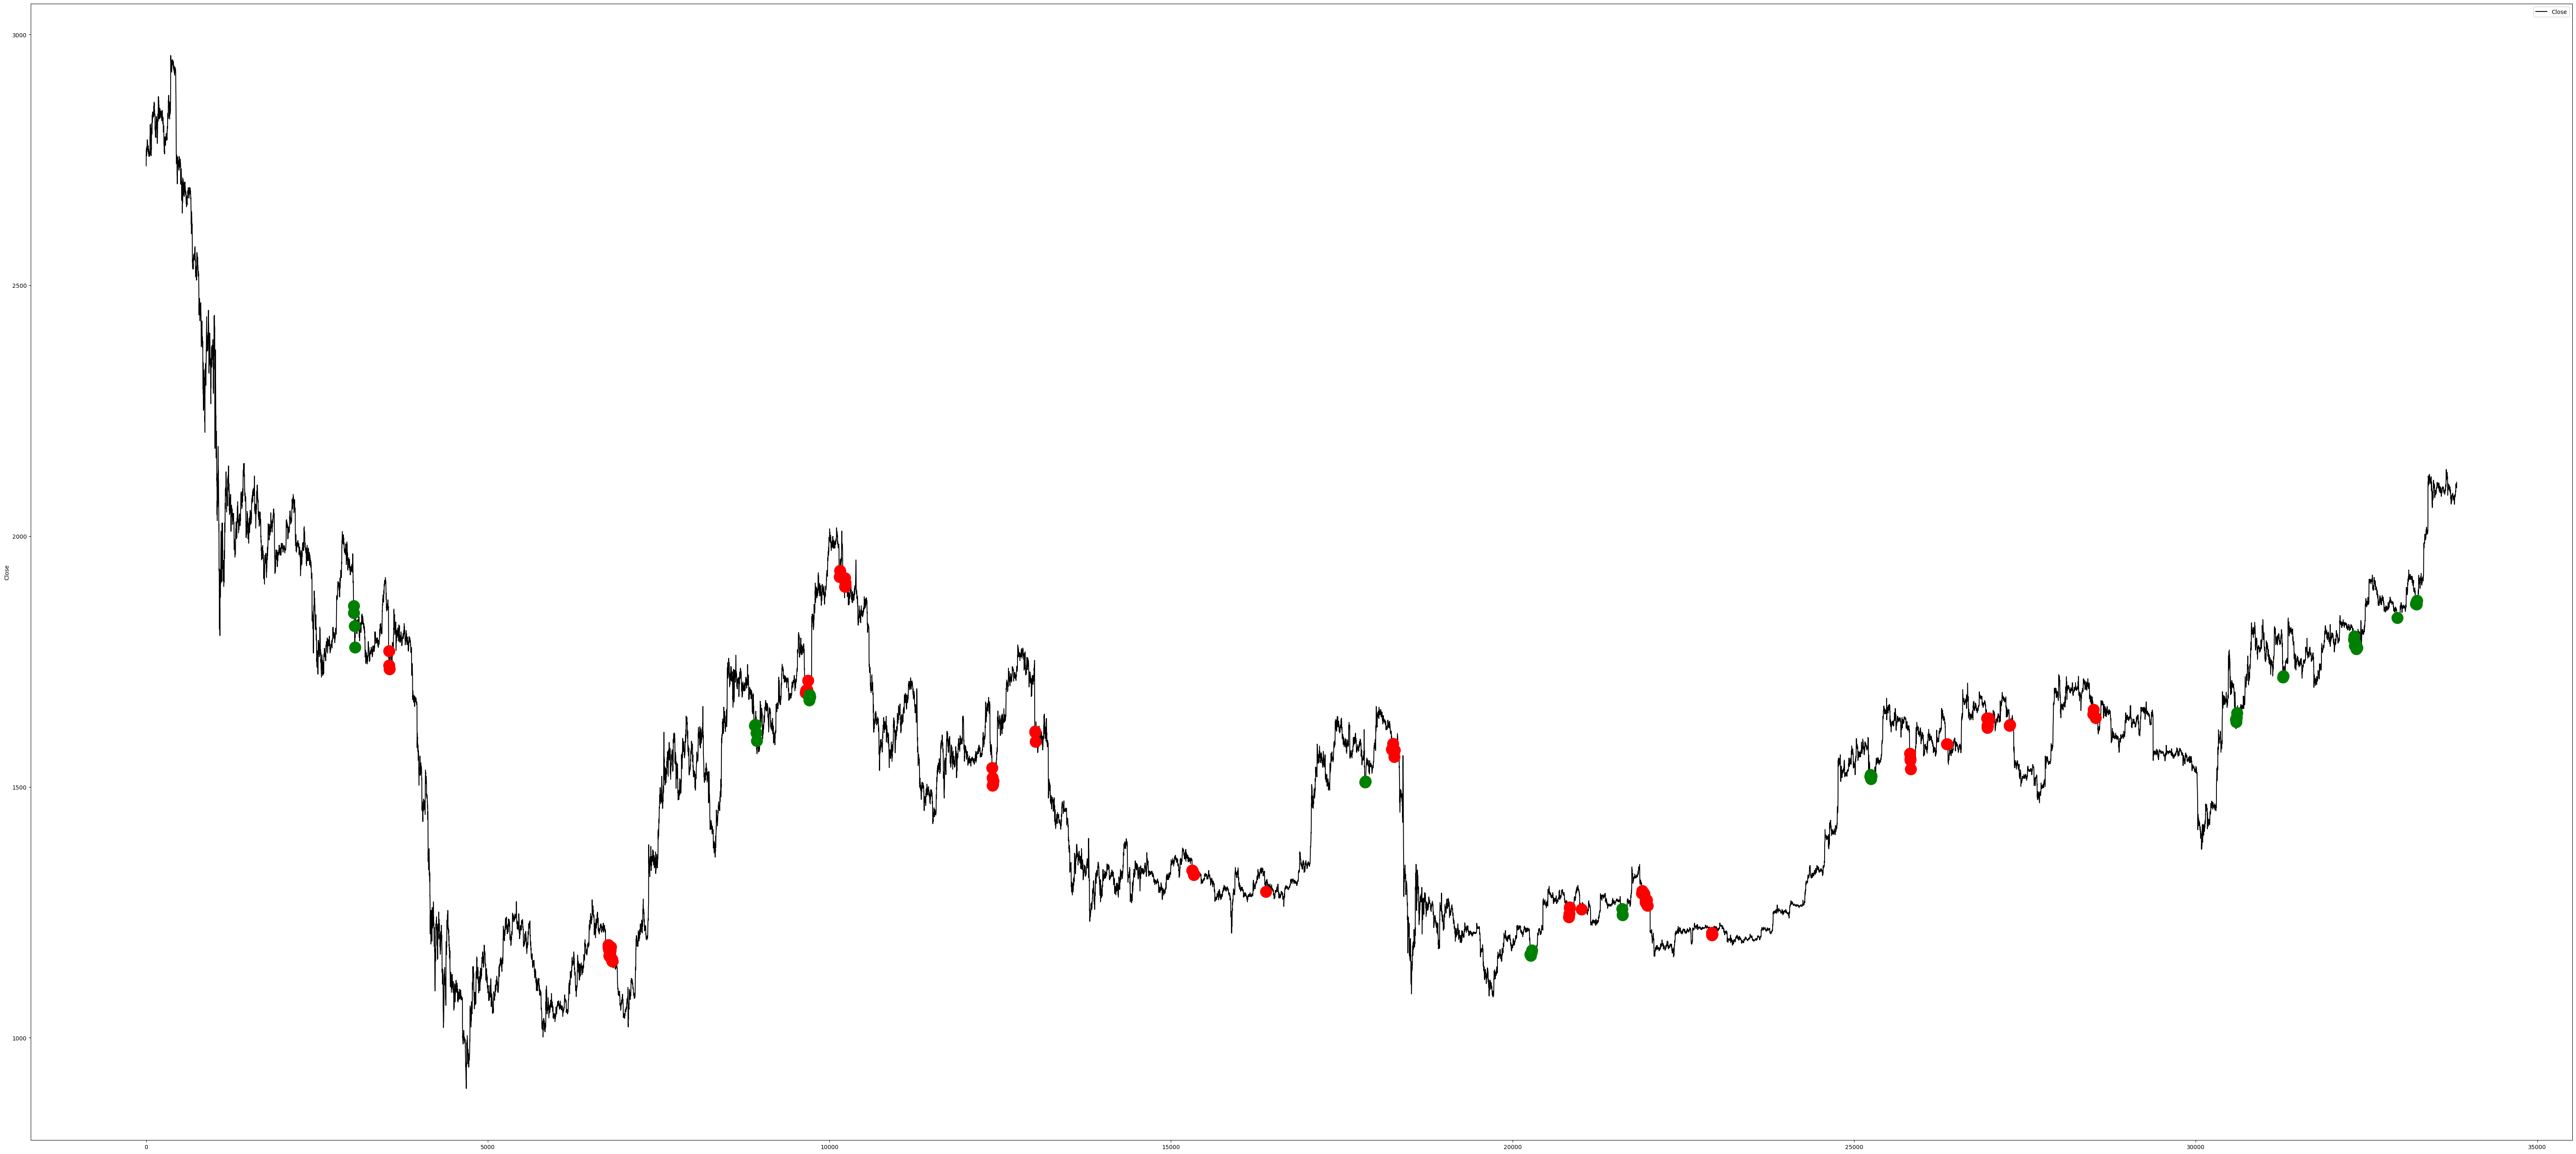

In [24]:
plt_df = raw_entry_df.copy()

plt.figure(figsize=(80, 36))
plt.ylabel('Close')
plt.plot(plt_df.Close, label = 'Close', c ='black')

i = 0
while i < len(plt_df):
    if pd.isna(plt_df.position[i]):
        i += 1
    elif plt_df.position[i] == 'Buy':
        j = i + 1
        while j < len(plt_df) and (pd.isna(plt_df.position[j]) or plt_df.position[j] == 'Buy'):
            j += 1
        if j < len(plt_df) and plt_df.position[j] == 'Sell':
            # Paint all previous 'Buy's green dot
            for k in range(i, j+1):
                plt.plot(k, plt_df.entry_p[k], 'go', label='_', markersize=20)
            i = j
        elif j < len(plt_df) and plt_df.position[j] == 'Stop':
            # Paint all previous 'Buy's red dot
            for k in range(i, j+1):
                plt.plot(k, plt_df.entry_p[k], 'ro', label='_', markersize=20)
            i = j + 1
        else:
            i = j
    else:
        i += 1

plt.legend()
plt.show()


# 之所以出現大量紅點，原因為：連續加倉會調整整個部位停利和停損，因此一些進倉部位會因為調高後的＂整個部位＂停損而出場，但該入場損益依舊為正
# 意思是該部位之停損已經高於許多前面部位之進場點位